In [13]:
import matplotlib.pyplot as plt
import json

def symmetry(shap, plot_name):
    """
    return value of symmetry for top/bot and left/right
    """
    check_list_top = [
        'lshoulder-lelbow', 'rshoulder-relbow', 'lelbow-lwrist', 'relbow-rwrist',
        'lshoulder', 'rshoulder', 'lelbow', 'relbow', 'lwrist', 'rwrist',
        'top_right', 'top_left']
    check_list_right = [
        'rshoulder-relbow', 'relbow-rwrist', 'rshoulder', 'relbow', 'rwrist',
        'rhip-rknee', 'rknee-rankle', 'rhip', 'rknee', 'rankle',
        'top_right', 'bot_right']

    top, bot, right, left = [], [], [], []
    nb_top, nb_bot, nb_right, nb_left = 0, 0, 0, 0

    for feature, shap_value in shap[plot_name].items():
        if feature == "Face":
            continue
        if plot_name[:11] == 'linear_data':
            feature = feature[:-2]
        if feature.lower() in check_list_top:
            top.append(shap_value)
            nb_top += 1
        else:
            bot.append(shap_value)
            nb_bot += 1
        if feature.lower() in check_list_right:
            right.append(shap_value)
            nb_right += 1
        else:
            left.append(shap_value)
            nb_left += 1

    top, bot, right, left = sum(top), sum(bot), sum(right), sum(left)

    if bot > top:
        sym_top_bot = round((bot / top), 2)
    else:
        sym_top_bot = round((top / bot), 2)
    if right > left:
        sym_left_right = round((right / left), 2) * -1
    else:
        sym_left_right = round((left / right), 2)

    return [sym_top_bot, sym_left_right]

In [14]:
# ouvrir shap dict
f = open('Data/V2/shap_v2.json')
shap = json.load(f)
f.close()

# ouvrir auc dict
f = open('Data/V2/auc_v2.json')
auc = json.load(f)
f.close()

In [15]:
datasets = [dataset for dataset in auc.keys()]

In [16]:
stats = auc
for dataset in datasets:
    t_b, l_r = [], []
    for label in ["_normal", "_anormal"]:
        stats[dataset]["mean"] = round(stats[dataset]["mean"], 2)
        stats[dataset]["std"] = round(stats[dataset]["std"], 2)
        stats[dataset]["sym" + label] = {}
        if dataset != "amplitudes":
            sym = symmetry(shap=shap, plot_name=dataset+label)
            stats[dataset]["sym" + label]["T-B"] = sym[0] 
            stats[dataset]["sym" + label]["L-R"] = sym[1] 
            t_b.append(sym[0])
            l_r.append(sym[1])
    stats[dataset]["sym_global"] = {
        "T-B": round(sum(t_b)/2, 2), 
        "L-R": round(sum(l_r)/2, 2)}

In [17]:
json = json.dumps(stats)
f = open("Data/V2/Stats/stats.json", "w")
f.write(json)
f.close()

In [19]:
datasets_to_remove = [
    'angular_velocity', 'angular_jurk', 'angular_data', 
    'amplitudes', 'angular_acceleration', 'linear_data']
for dataset in datasets_to_remove:
    datasets.remove(dataset)

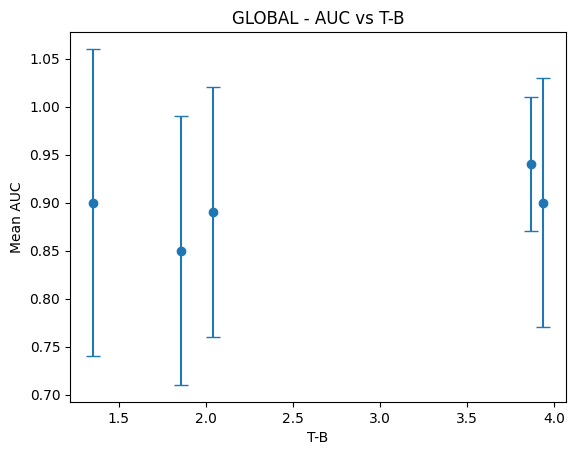

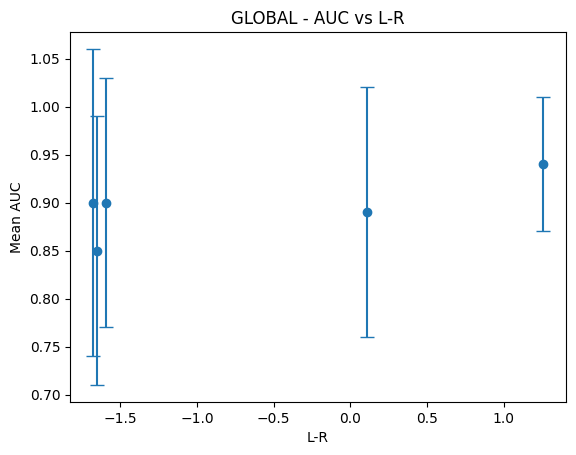

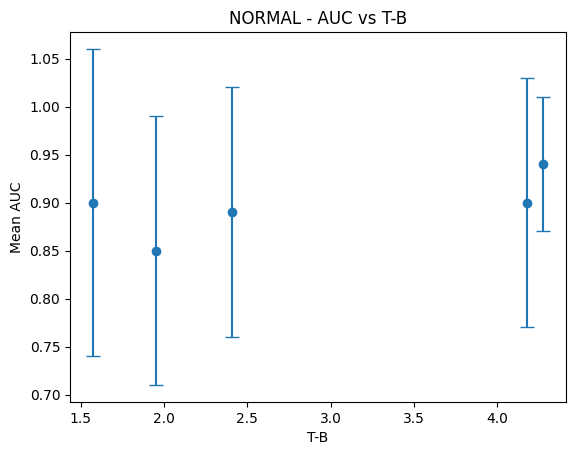

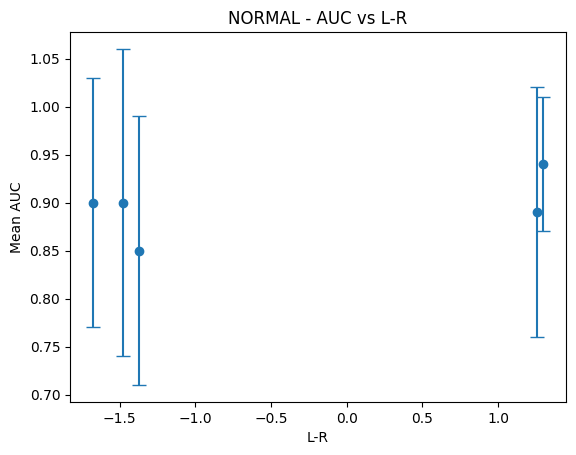

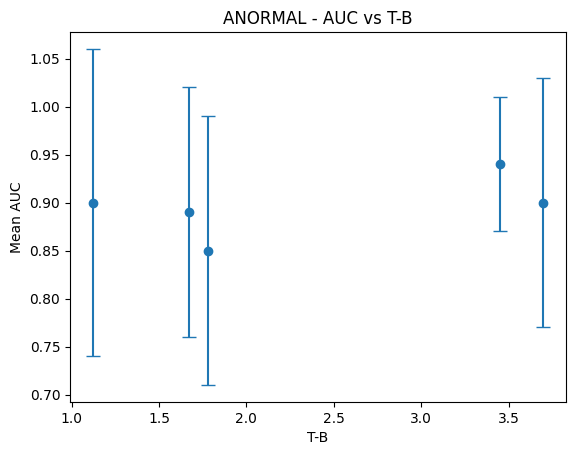

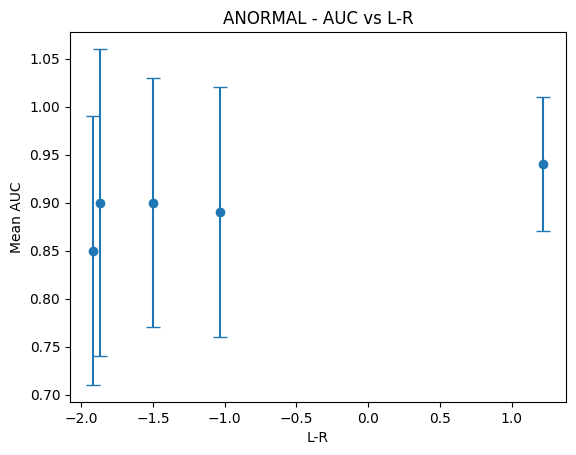

In [30]:
for label in ["global", "normal", "anormal"]:
    for sym_type in ["T-B", "L-R"]:

        x = [stats[dataset]["sym_"+label][sym_type] for dataset in datasets]
        y = [stats[dataset]["mean"] for dataset in datasets]
        y_error = [stats[dataset]["std"] for dataset in datasets]

        combined = zip(x, y, y_error)
        sorted_combined = sorted(combined, key=lambda x: x[0])
        x_sorted, y_sorted, y_error_sorted = zip(*sorted_combined)

        fig, ax = plt.subplots()

        plt.errorbar(x_sorted, y_sorted, yerr=y_error_sorted, fmt='o', capsize=5)

        plt.xlabel(sym_type)
        plt.ylabel("Mean AUC")
        plt.title(label.upper() + " - AUC vs " + sym_type)

        plt.savefig("Data/V2/Stats/" + label + "_AUC_vs_" + sym_type + ".png");
